In [12]:
%pylab inline
import pandas as pd
from scipy.special import gamma
import scipy.stats
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
import matplotlib as mpl
plt.rcParams['figure.dpi'] = 200


from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
letter_bbox_props = dict(
    boxstyle="round,pad=0.,rounding_size=0.2",fc='w',alpha=0.7,
    ec='none'
)
letter_text_props = dict(size='large', weight='bold')

def letter_plot(letter):
    ax = gca()
    at = AnchoredText(letter,loc=2, frameon=True, prop=letter_text_props)
    ax.add_artist(at)
    setp(at.patch,**letter_bbox_props)        
    
    
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf'])

def _aonrstar(per, rhostar):
    """
    rhostar: mean stellar density in g/cc
    per: period in days
    """
    aonrstar_0 = 215.032 # nominal value, earth-sun
    rhostar_0 = 1.41 # nominal value, earth-sun
    per_0 = 365 # nominal value, earth-sun
    _aonrstar = aonrstar_0 * (rhostar / rhostar_0)**(1/3.) * (per / per_0)**(2/3.)
    return _aonrstar
""
def _impact(aonrstar, cosinc, ecc, omega):
    impact = aonrstar * cosinc * (1 - ecc**2) / (1 + ecc * sin(omega) )
    return impact

def _xfactor(ecc, omega):
    """Equation 16 in Winn 2010"""
    return sqrt(1 - ecc**2) * (1 + ecc*sin(omega))**-1

def _tau(per, aonrstar, cosinc, ecc, omega, ):
    inc = arccos(cosinc)
    b = _impact(aonrstar, cosinc, ecc, omega)
    X = _xfactor(ecc, omega)
    _tau = X * per / pi * arcsin(np.sqrt(1 - b**2) / sin(inc)/ aonrstar  ) 
    return _tau

    
def simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma):
    n = len(ecc)
    aonrstar = _aonrstar(per, rhostar)
    impact  = _impact(aonrstar, cosinc, ecc, omega)
    tau = _tau(per, aonrstar, cosinc, ecc, omega) * 24
    tau_meas = 10**(log10(tau) + np.random.randn(n) * tau_meas_sigma)
    rhostar_meas = 10**(log10(rhostar) + np.random.randn(n) * rhostar_meas_sigma)
    tau0 = 2.036 * per**(1/3.) * rhostar_meas**(-1./3)
    df = pd.DataFrame(dict(
        tau=tau,tau_meas=tau_meas,tau0=tau0,
        impact=impact,ecc=ecc,b=impact,aonrstar=aonrstar,
        rhostar=rhostar,rhostar_meas=rhostar_meas
    ))
    df['tau_ratio'] = df.eval('tau_meas / tau0')
    df = df.dropna()
    nplanet = len(per)
    ntransit = len(df)
    ntransit_expected = ((1-ecc**2)**-1 * aonrstar**-1).sum()
    print("{}/{} planets transit, {} expected".format(ntransit,nplanet,ntransit_expected))

    # Explore the affect of varios cuts
    ratios = arange(0,2,0.01)
    comp = [1.0*(df['tau_ratio'] < r).sum()/ntransit  for r in ratios]
    comp = pd.DataFrame(dict(ratio=ratios,comp=comp))
    return df,comp


Populating the interactive namespace from numpy and matplotlib


In [67]:
np.random.seed(0)
n = 1000000
per = 20 * ones(n) 
omega = np.random.rand(n) * 2*pi
cosinc = np.random.rand(n)

ecc = np.zeros(n)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0 # dex
tau_meas_sigma = 0 # dex
df0,comp0 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma)
label0 = r'$e = 0$, $\sigma(\rho) / \rho = 0\%$'

# rho uncert
ecc = np.zeros(n)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0.06 # dex 15%
tau_meas_sigma = 0 # dex
df1,comp1 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma) 
label1 = r'$e = 0$, $\sigma(\rho) / \rho = 15\%$'

# tau uncert
ecc = np.zeros(n)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0.00 # 
tau_meas_sigma = 0.014 # dex 3.5%
df2,comp2 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma) 
#label1 = r'$e = 0$, $\sigma(\rho) / \rho = 15\%$'\

## Van Eylen distribution for singles
ecc = abs(randn(n) * 0.3)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0.0 # 
tau_meas_sigma = 0 # dex
df3,comp3 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma) 
label3 = r'$e = N(0,0.3)$, $\sigma(\rho) / \rho = 0\%$'

## Kipping eccentricity distribution
a = 0.867
b = 3.03
dist = scipy.stats.beta(a,b)
ecc = dist.rvs(n)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0.0 
tau_meas_sigma = 0 # dex
df4,comp4 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma) 
label4 = r'$e = \beta(0.867,3.03)$, $\sigma(\rho) / \rho = 0\%$'


## Van Eylen distribution for singles, desnity uncert, and tau uncert
ecc = abs(randn(n) * 0.3)
rhostar = 1.4 * ones(n) # gram / cc
rhostar_meas_sigma = 0.06 # 
tau_meas_fracerr = 10**(-1.5 + 0.5*np.random.randn(n))
tau_meas_fracerr = np.min([np.ones_like(tau_meas_fracerr),tau_meas_fracerr],axis=0)
tau_meas_sigma = log10(1 + tau_meas_fracerr)
df5,comp5 = simulation(per, ecc, omega, rhostar, rhostar_meas_sigma, tau_meas_sigma) 
#label3 = r'$e = N(0,0.3)$, $\sigma(\rho) / \rho = 0\%$'

/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt


32349/1000000 planets transit, 32312.3970868 expected
32349/1000000 planets transit, 32312.3970868 expected
32349/1000000 planets transit, 32312.3970868 expected


/Users/petigura/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in sqrt


36996/1000000 planets transit, 35147.2473791 expected
36540/1000000 planets transit, 36568.1004335 expected
36904/1000000 planets transit, 33480.191588 expected


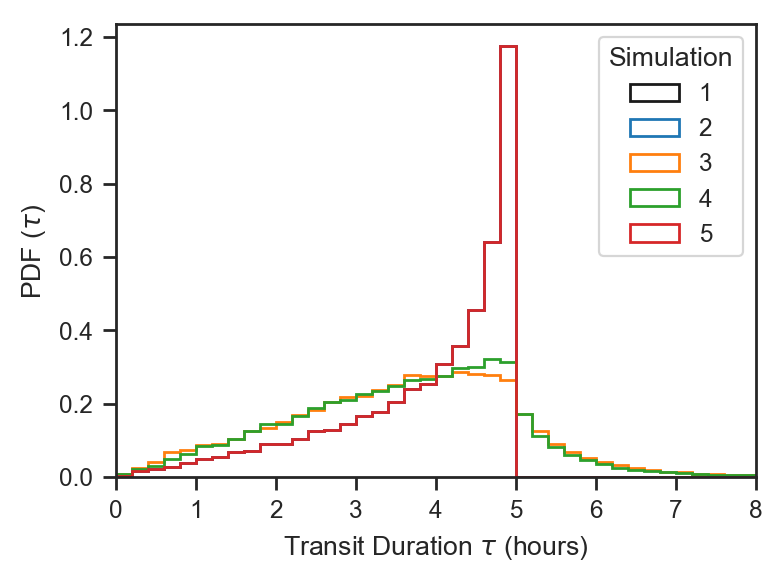

In [68]:
figure(figsize=(4,3))
kw = dict(histtype='step',bins=arange(0,10,0.2),normed=True,lw=1)
df0.tau.hist(label='1',color='k',**kw)
df1.tau.hist(label='2',**kw)
df3.tau.hist(label='3',**kw)
df4.tau.hist(label='4',**kw)
df2.tau.hist(label='5',**kw)
#df5.tau.hist(label='5',**kw)
xlabel(r'Transit Duration $\tau$ (hours)')
ylabel(r'PDF ($\tau$)')
legend(title='Simulation')
xlim(0,8)
grid()
tight_layout()

gcf().savefig('paper/fig_tau-hist.pdf')


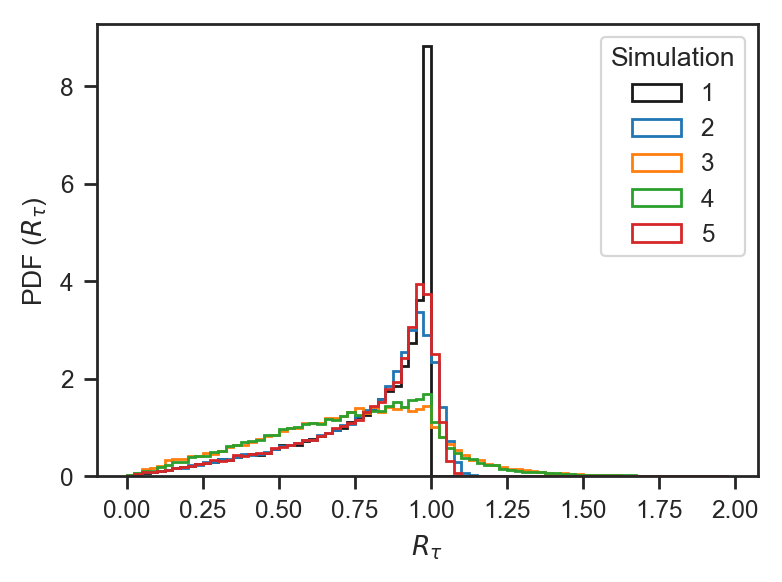

In [69]:
figure(figsize=(4,3))
kw = dict(histtype='step',bins=arange(0,2,0.025),normed=True,lw=1)
df0.tau_ratio.hist(label='1',color='k',**kw)
df1.tau_ratio.hist(label='2',**kw)
df3.tau_ratio.hist(label='3',**kw)
df4.tau_ratio.hist(label='4',**kw)
df2.tau_ratio.hist(label='5',**kw)
ylabel(r'PDF ($R_\tau$)')
xlabel(r'$R_\tau$')
legend(title='Simulation')
grid()
tight_layout()
savefig('paper/fig_tau-ratio-hist.pdf')

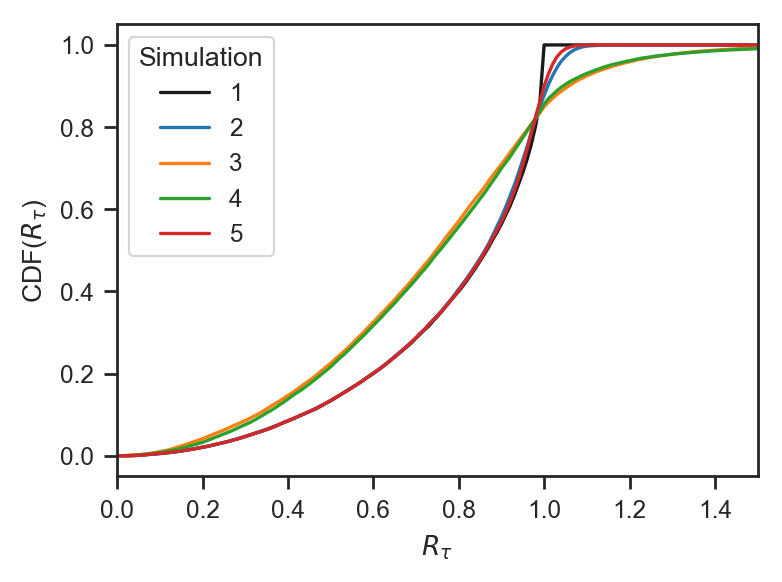

In [70]:
figure(figsize=(4,3))
plot(comp0.ratio,comp0.comp,color='k',label='1')
plot(comp1.ratio,comp1.comp,label='2')
plot(comp3.ratio,comp3.comp,label='3')
plot(comp4.ratio,comp4.comp,label='4')
plot(comp2.ratio,comp2.comp,label='5')
#plot(comp4.ratio,comp5.comp,label='5')
ylabel(r'CDF($R_\tau$)')
xlabel(r'$R_\tau$')
xlim(0,1.5)
legend(title='Simulation')
tight_layout()
savefig('paper/fig_ratio-cdf.pdf')

final purity [fraction of sample with b < 0.8] =  0.975472907983


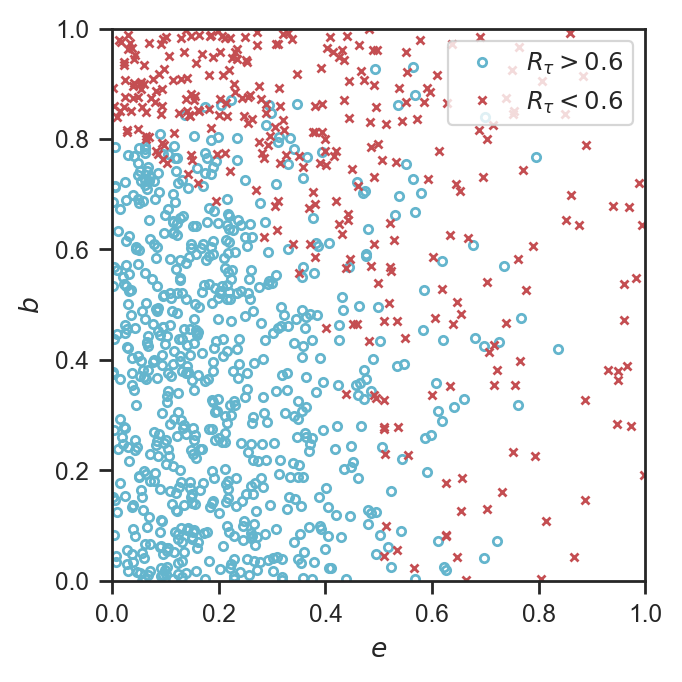

In [92]:
clf()
df = df3.copy()
figure(figsize=(3.5,3.5))
sns.set_color_codes()
sns.color_palette("muted")
sample = df.sample(1000)
sample1 = sample.query('tau_ratio < 0.6')
sample2 = sample.query('tau_ratio > 0.6')
plot(sample2.ecc,sample2.b,'oc',ms=3,mew=1,mfc='none',label=r'$R_\tau > 0.6$')
plot(sample1.ecc,sample1.b,'xr',ms=3,mew=1,label=r'$R_\tau < 0.6$')
xlim(0,1)
ylim(0,1)
xlabel(r'$e$')
ylabel(r'$b$')
tight_layout()
legend(loc='upper right')
savefig('paper/fig_ecc-impact.pdf')

truepos = df.eval('tau_ratio > 0.6 and b < 0.8').sum()
falsepos = df.eval('tau_ratio > 0.6 and b > 0.8').sum()
trueneg = df.eval('tau_ratio < 0.6 and b > 0.8').sum()
falseneg = df.eval('tau_ratio < 0.6 and b < 0.8').sum()
n = 1.0*len(df)
truepos/n, falsepos/n, trueneg/n, falseneg/n

print "final purity [fraction of sample with b < 0.8] = " ,1.0 *df.eval('tau_ratio > 0.6 and b < 0.8').sum() / df.eval('tau_ratio > 0.6').sum()

In [61]:
%reload_ext autoreload
import ckscool.io

read table m17+cdpp+gaia2+ber19 from /Users/petigura/Research/CKS-Cool/ckscool/../cache/field-ber19-plnt-giso/load_table_cache.hdf
Populating the interactive namespace from numpy and matplotlib


/Users/petigura/Research/CKS-Cool/ckscool/cuts/occur.py:252: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.cuttypes=cuttypes
/Users/petigura/anaconda2/envs/ckscool/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


0.0354281422385734

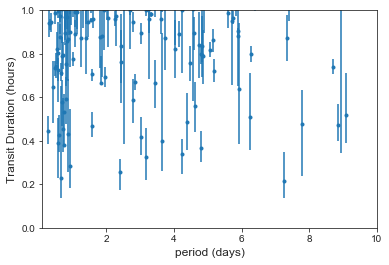

In [163]:
import ckscool.io
reload(ckscool.io)
#df = ckscool.io.load_table('planets-cuts2+iso')
df = ckscool.io.load_table('planets-cuts1')
#df = df[~df.isany]
df = df[~df.isnotreliable]
%pylab inline


#loglog()
yerr = np.vstack([-df.dr25_tau_err2,df.dr25_tau_err1])
errorbar(df.koi_period,df.dr25_tau,fmt='.',yerr=yerr)
fracyerr = np.nanmean(yerr,axis=0) / df.dr25_tau
xlabel('period (days)')
ylabel('Transit Duration (hours)')
xlim(0.1,10)
ylim(0,1)


fracyerr.median()

1397    5129
2858    2925
3334    3089
4693    7144
5229     952
5737    3913
6076    7361
6740    8061
7025    4595
Name: id_koi, dtype: int64

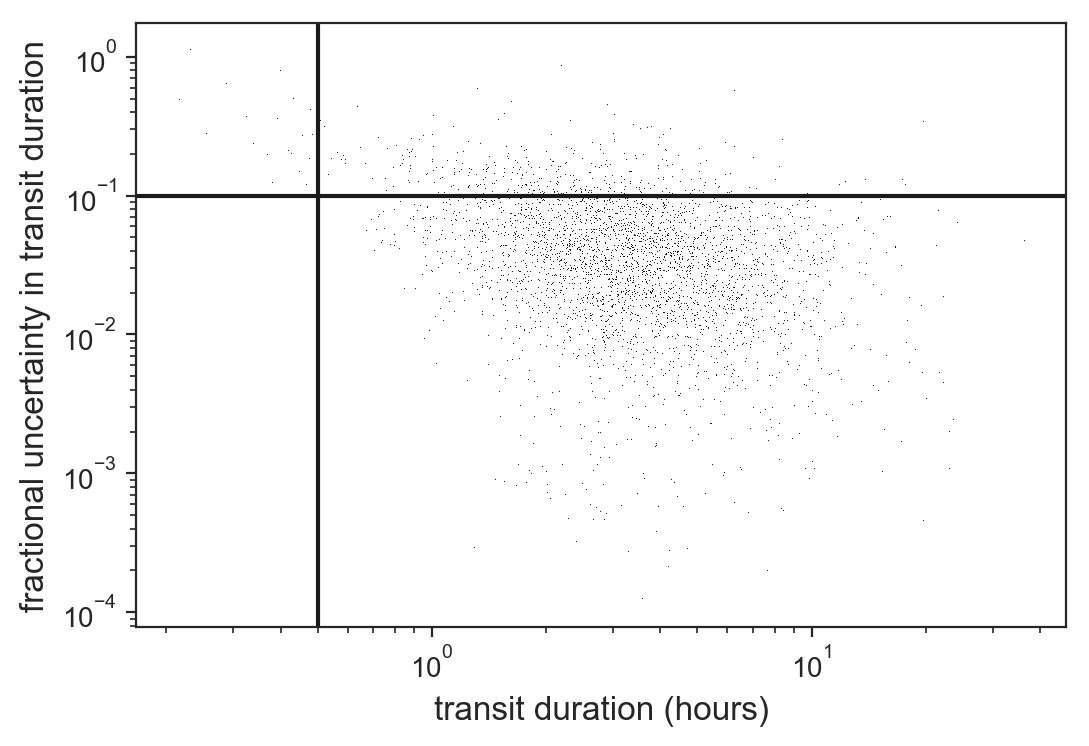

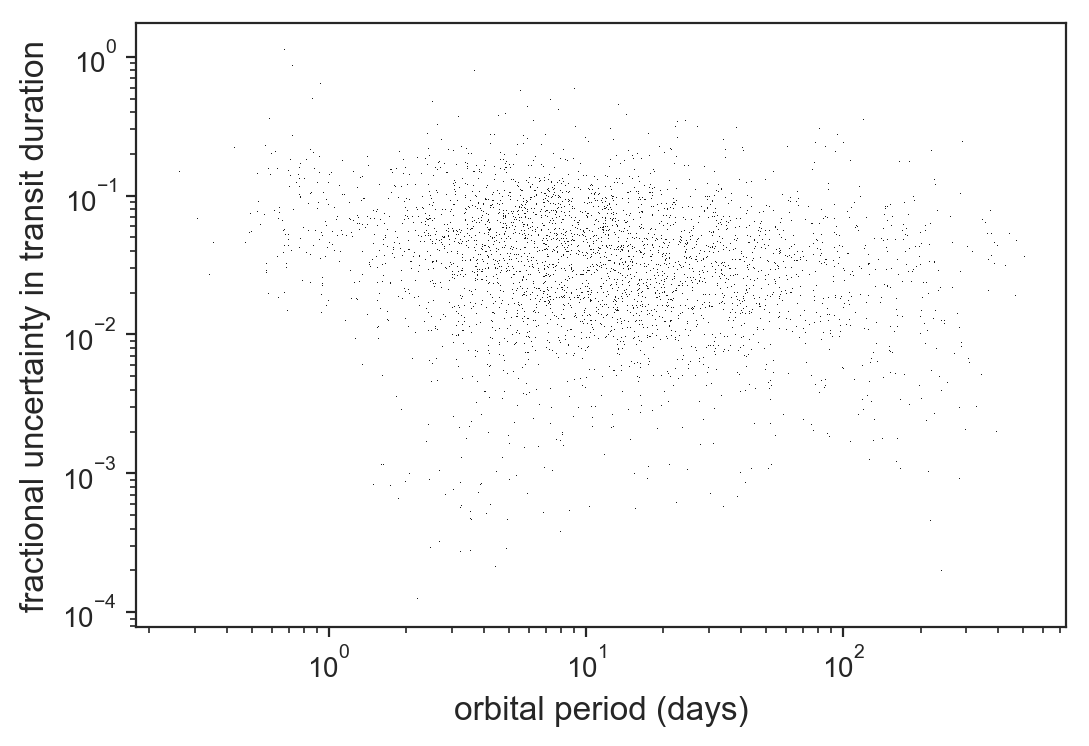

In [75]:
loglog()
plot(df.dr25_tau,cut,',')
xlabel('transit duration (hours)')
ylabel('fractional uncertainty in transit duration')
axvline(0.5)
axhline(0.1)
figure()
loglog()
plot(df.koi_period,fracyerr,',')
xlabel('orbital period (days)')
ylabel('fractional uncertainty in transit duration')

df.query('dr25_tau_err1 / dr25_tau > 0.2').id_koi


In [171]:
1.0 *(fracyerr > 0.2).sum()/ fracyerr.count()

0.02294792586054722

In [160]:
df[['koi_model_snr','dr25_tau']].median()

koi_model_snr    23.200000
dr25_tau          3.275746
dtype: float64